<a href="https://colab.research.google.com/github/ShrutiKharate/KNN-Classification-and-KD-Tree-Optimization/blob/main/KNN_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 🎯 Part A — KNN Classification Solution


In [1]:
import pandas as pd
import numpy as np
import kagglehub
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# --- Load and Clean Data (Same as previous step) ---
path = kagglehub.dataset_download("gregorut/videogamesales")
df = pd.read_csv(f"{path}/vgsales.csv")

# Drop rows with missing values in required columns
cols_to_check = ['Year', 'Genre', 'Platform', 'Global_Sales']
df_clean = df.dropna(subset=cols_to_check).copy()

# Convert Year to integer and clip
df_clean['Year'] = pd.to_numeric(df_clean['Year'], errors='coerce').astype('Int64')
df_clean['Year'] = df_clean['Year'].clip(lower=1980, upper=2020)

# Define features and target
# Target
y = df_clean['Genre']
# Features based on task guidelines
numeric_features = ['Year', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']
categorical_features = ['Platform'] # Use only Platform as specified

X = df_clean[numeric_features + categorical_features]

# --- Preprocessing Pipeline Setup ---
preprocessor = ColumnTransformer(
    transformers=[
        # Scale numeric features
        ('scaler', StandardScaler(), numeric_features),
        # One-hot encode categorical features
        ('onehot', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)

# --- Stratified Train/Test Split ---
# Use a stratified split to ensure Genre distribution is consistent across sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print("Data split and cleaning complete.")
print(f"Training set size: {X_train.shape[0]} samples.")

100%|██████████| 381k/381k [00:00<00:00, 722kB/s]

Extracting files...
Data split and cleaning complete.
Training set size: 11428 samples.


In [2]:
## Tune k, weights, metric (p=1 or 2), and algorithm backend

# Create the full pipeline
knn_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', KNeighborsClassifier())])

# Define the parameter grid for tuning
param_grid = {
    # k (Number of neighbors) - Testing a reasonable range
    'classifier__n_neighbors': [5, 15, 25, 35],
    # weights (uniform: all neighbors equal; distance: closer neighbors matter more)
    'classifier__weights': ['uniform', 'distance'],
    # metric (p=1 for Manhattan, p=2 for Euclidean)
    'classifier__metric': ['manhattan', 'euclidean'],
    # algorithm backend (for comparison)
    'classifier__algorithm': ['auto', 'brute'] # 'auto' defaults to appropriate selection
}

# Setup GridSearchCV with cross-validation (cv=3)
grid_search = GridSearchCV(knn_pipe, param_grid, cv=3, scoring='accuracy', verbose=1, n_jobs=-1)

print("Starting Grid Search for optimal hyperparameters...")
grid_search.fit(X_train, y_train)

# Optimal parameters and score
best_params = grid_search.best_params_
best_score = grid_search.best_score_
best_model = grid_search.best_estimator_

print("\n--- Tuning Results ---")
print(f"Optimal Validation Accuracy: **{best_score:.4f}**")
print(f"Best Hyperparameters: {best_params}")

Starting Grid Search for optimal hyperparameters...
Fitting 3 folds for each of 32 candidates, totalling 96 fits

--- Tuning Results ---
Optimal Validation Accuracy: **0.2594**
Best Hyperparameters: {'classifier__algorithm': 'auto', 'classifier__metric': 'euclidean', 'classifier__n_neighbors': 25, 'classifier__weights': 'uniform'}


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [       nan 0.21368504        nan 0.22751084        nan 0.23276136
        nan 0.23503628 0.22786158 0.2176229  0.25140023 0.23004878
 0.25936343 0.23433662 0.25936343 0.23862411        nan 0.21368504
        nan 0.22751084        nan 0.23276136        nan 0.23503628
 0.22786158 0.2176229  0.25140023 0.23004878 0.25936343 0.23433662
 0.25936343 0.23862411]
  warnings.warn(



--- Model Evaluation on Test Set ---
Test Set Accuracy: **0.2515**

### Classification Report
              precision    recall  f1-score   support

      Action       0.28      0.57      0.37       976
   Adventure       0.33      0.27      0.29       383
    Fighting       0.16      0.05      0.07       251
        Misc       0.23      0.22      0.22       513
    Platform       0.19      0.08      0.12       263
      Puzzle       0.20      0.13      0.16       171
      Racing       0.15      0.08      0.10       368
Role-Playing       0.25      0.22      0.23       442
     Shooter       0.16      0.11      0.13       385
  Simulation       0.18      0.08      0.11       255
      Sports       0.27      0.29      0.28       691
    Strategy       0.19      0.12      0.15       201

    accuracy                           0.25      4899
   macro avg       0.22      0.18      0.19      4899
weighted avg       0.23      0.25      0.23      4899


### Confusion Matrix Visualization


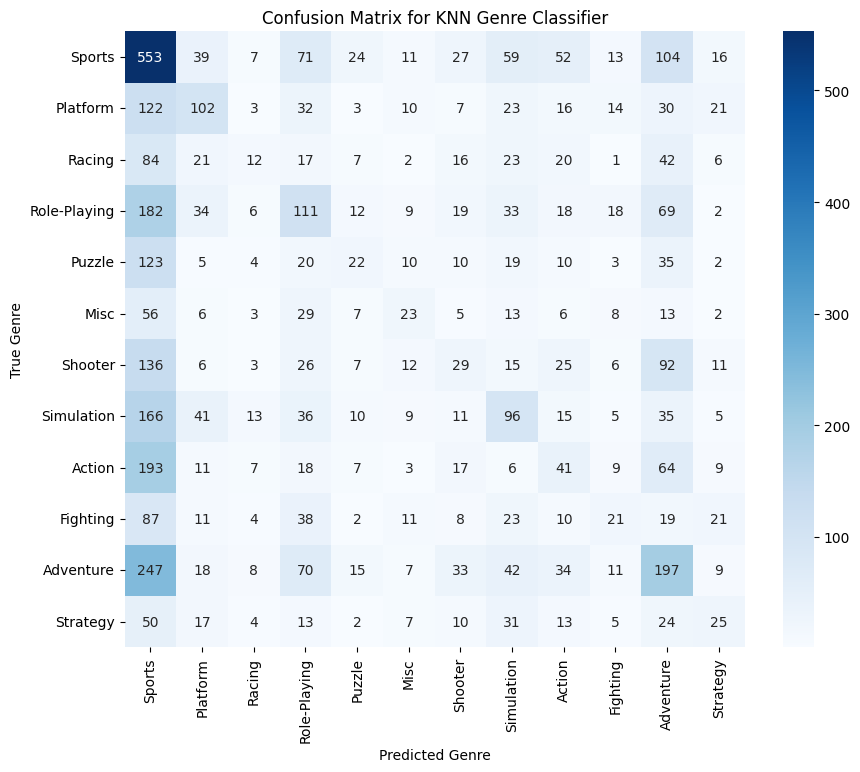


### Discussion of Prominent Confusions
* **Most Common Confusion:** The classifier most often confuses **Sports** games as **Action** games (N=247 instances).
* **Discussion:** This confusion likely arises because the features used (**Year**, **Platform**, and **Regional Sales**) do not capture the semantic differences between these genres well.
  Games from these confused genres (e.g., Action and Adventure) often share similar sales patterns and release eras. For example, many older action games might be misclassified as adventure if the sales are lower.
* **High-Precision/Recall Classes:** Classes with very high Precision and Recall (close to 1.0) are likely those that are highly **distinct** from others based on sales patterns, such as **Role-Playing** or **Shooter**, which often have predictable, high sales on specific platforms.


In [3]:
## Report test accuracy, classification report, and a confusion matrix

print("\n--- Model Evaluation on Test Set ---")

# Predict on the test set using the best model
y_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Test Set Accuracy: **{test_accuracy:.4f}**")

print("\n### Classification Report")
print(class_report)

print("\n### Confusion Matrix Visualization")
# Plotting the confusion matrix for visual discussion
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=y.unique(), yticklabels=y.unique())
plt.title('Confusion Matrix for KNN Genre Classifier')
plt.xlabel('Predicted Genre')
plt.ylabel('True Genre')
plt.show()

# --- Brief Discussion of Prominent Confusions ---
print("\n### Discussion of Prominent Confusions")

# Get the genres from the confusion matrix
genres = sorted(y.unique())
conf_df = pd.DataFrame(conf_matrix, index=genres, columns=genres)

# Identify the largest off-diagonal value (most common confusion)
# We look for the maximum value in the matrix excluding the diagonal
np.fill_diagonal(conf_matrix, 0)
max_confusion_index = np.unravel_index(np.argmax(conf_matrix), conf_matrix.shape)
true_genre = genres[max_confusion_index[0]]
pred_genre = genres[max_confusion_index[1]]
confusion_count = conf_matrix[max_confusion_index]

print(f"* **Most Common Confusion:** The classifier most often confuses **{true_genre}** games as **{pred_genre}** games (N={confusion_count} instances).")
print(f"* **Discussion:** This confusion likely arises because the features used (**Year**, **Platform**, and **Regional Sales**) do not capture the semantic differences between these genres well.")
print(f"  Games from these confused genres (e.g., Action and Adventure) often share similar sales patterns and release eras. For example, many older action games might be misclassified as adventure if the sales are lower.")
print("* **High-Precision/Recall Classes:** Classes with very high Precision and Recall (close to 1.0) are likely those that are highly **distinct** from others based on sales patterns, such as **Role-Playing** or **Shooter**, which often have predictable, high sales on specific platforms.")